In [1]:
"""Python implementation of a Bayesian probabilistic learner.

This model was originally described in Behrens et al. Nat Neuro 2007.

The code here was adapted from the original C++ code provided by
Tim Behrens.

"""
from __future__ import division
import numpy as np
from numpy import log, exp, power, pi
from scipy.special import gammaln
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    import warnings
    message = "Could not import seaborn; plotting will not work."
    warnings.warn(message, UserWarning)


class ProbabilityLearner(object):

    def __init__(self, p_step=.01, I_step=.1):

        # Set up the parameter grids
        p_grid = make_grid(.01, .99, p_step)
        self.p_grid = p_grid
        I_grid = make_grid(log(2), log(10000), I_step)
        self.I_grid = I_grid

        self._p_size = p_grid.size
        self._I_size = I_grid.size

        # Set up the transitional distribution on p
        joint_grid = np.meshgrid(p_grid, p_grid, I_grid, indexing="ij")
        p_trans = np.vectorize(p_trans_func)(*joint_grid)
        self._p_trans = p_trans / p_trans.sum(axis=0)

        # Initialize the learner and history
        self.reset()

    @property
    def p_hats(self):
        return np.atleast_1d(self._p_hats)

    @property
    def I_hats(self):
        return np.atleast_1d(self._I_hats)

    @property
    def data(self):
        return np.atleast_1d(self._data)

    def fit(self, data):
        """Fit the model to a sequence of Bernoulli observations."""
        if np.isscalar(data):
            data = [data]
        for y in data:
            self._update(y)
            pI = self.pI
            self.p_dists.append(pI.sum(axis=1))
            self.I_dists.append(pI.sum(axis=0))
            self._p_hats.append(np.sum(self.p_dists[-1] * self.p_grid))
            self._I_hats.append(np.sum(self.I_dists[-1] * self.I_grid))
            self._data.append(y)

    def _update(self, y):
        """Perform the Bayesian update for a trial based on y."""

        # Information leak (increase in the variance of the joint
        # distribution to reflect uncertainty of a new trial)
        # -------------------------------------------------------

        pI = self.pI

        # Multiply P(p_p+1 | p_i, I) by P(p_i, I) and
        # integrate out p_i, which gives P(p_i+1, I)

        # pI = (self._p_trans * pI).sum(axis=1)

        # Equivalent but twice as fast:
        pI = np.einsum("ijk,jk->ik", self._p_trans, pI)

        # Update P(p_i+1, I) based on the newly observed data
        # ----------------------------------------------------------

        likelihood = self.p_grid if y else 1 - self.p_grid
        pI *= likelihood[:, np.newaxis]

        # Normalize the new distribution
        # ------------------------------

        self.pI = pI / pI.sum()

    def reset(self):
        """Reset the history of the learner."""
        # Initialize the joint distribution P(p, I, k)
        pI = np.ones((self._p_size, self._I_size))
        self.pI = pI / pI.sum()

        # Initialize the memory lists
        self.p_dists = []
        self.I_dists = []
        self._p_hats = []
        self._I_hats = []
        self._data = []

    def plot_history(self, ground_truth=None, **kwargs):
        """Plot the data and posterior means from the history."""
        blue, green = sns.color_palette("deep", n_colors=2)

        trials = np.arange(self.data.size)
        xlim = trials.min(), trials.max()

        f, (p_ax, I_ax) = plt.subplots(2, 1, sharex=True, **kwargs)
        p_ax.plot(trials, self.p_hats, c=blue)
        p_ax.scatter(trials, self.data, c=".25", alpha=.5, s=15)

        if ground_truth is not None:
            p_ax.plot(trials, ground_truth, c="dimgray", ls="--")
        p_ax.set_ylabel("$\hat p$", size=16)
        p_ax.set(xlim=xlim, ylim=(-.1, 1.1))

        I_ax.plot(trials, self.I_hats, c=green)
        I_ax.set_ylabel("$\hat I$", size=16)
        I_ax.set(ylim=(2, 10), xlabel=("Trial"))
        f.tight_layout()

    def plot_joint(self, cmap="BuGn"):
        """Plot the current joint distribution P(p, I)."""
        pal = sns.color_palette(cmap, 256)
        lc = pal[int(.7 * 256)]
        bg = pal[0]

        fig = plt.figure(figsize=(7, 7))
        gs = plt.GridSpec(6, 6)

        p_lim = self.p_grid.min(), self.p_grid.max()
        I_lim = self.I_grid.min(), self.I_grid.max()

        ax1 = fig.add_subplot(gs[1:, :-1])
        ax1.set(xlim=p_lim, ylim=I_lim)

        ax1.contourf(self.p_grid, self.I_grid, self.pI.T, 30, cmap=cmap)

        sns.axlabel("$p$", "$I$", size=16)

        ax2 = fig.add_subplot(gs[1:, -1], axis_bgcolor=bg)
        ax2.set(ylim=I_lim)
        ax2.plot(self.pI.sum(axis=0), self.I_grid, c=lc, lw=3)
        ax2.set_xticks([])
        ax2.set_yticks([])

        ax3 = fig.add_subplot(gs[0, :-1], axis_bgcolor=bg)
        ax3.set(xlim=p_lim)
        ax3.plot(self.p_grid, self.pI.sum(axis=1), c=lc, lw=3)
        ax3.set_xticks([])
        ax3.set_yticks([])

    def show_model(self):
        """Render the model as a Bayes net using daft."""
        import daft
        gray = ".3"
        pgm = daft.PGM((3, 3), node_ec=gray)
        scale = 1.5

        pgm.add_node(daft.Node("v", r"$v$", 1.5, 2.5, scale))
        pgm.add_node(daft.Node("pim1", r"$p_{i-1}$", .5, 1.5, scale))
        pgm.add_node(daft.Node("pi", r"$p_i$", 2.5, 1.5, scale))
        pgm.add_node(daft.Node("yim1", r"$y_{i-1}$", .5, .5, scale, observed=True))
        pgm.add_node(daft.Node("yi", r"$y_i$", 2.5, .5, scale, observed=True))

        kws = {"plot_params": {"ec": gray, "fc": gray}}
        pgm.add_edge("v", "pim1", **kws)
        pgm.add_edge("v", "pi", **kws)
        pgm.add_edge("pim1", "pi", **kws)
        pgm.add_edge("pim1", "yim1", **kws)
        pgm.add_edge("pi", "yi", **kws)

        pgm.render()
        return pgm


class VolatilityLearner(ProbabilityLearner):

    def __init__(self, p_step=.02, I_step=.2, k_step=.2, k_floor = 5e-4, k_celling = 20, i_floor = 2, i_celling = 1000):

        # Set up the parameter grids
        self.p_grid = make_grid(.01, .99, p_step)
        self.I_grid = make_grid(log(i_floor), log(i_celling), I_step)
        self.k_grid = make_grid(log(k_floor), log(k_celling), k_step)

        self._p_size = self.p_grid.size
        self._I_size = self.I_grid.size
        self._k_size = self.k_grid.size

        # Set up the transitional distributions
        I_trans = np.vectorize(I_trans_func)(*np.meshgrid(self.I_grid,
                                                          self.I_grid,
                                                          self.k_grid,
                                                          indexing="ij"))
        self._I_trans = I_trans / I_trans.sum(axis=0)

        p_trans = np.vectorize(p_trans_func)(*np.meshgrid(self.p_grid,
                                                          self.p_grid,
                                                          self.I_grid,
                                                          indexing="ij"))
        self._p_trans = p_trans / p_trans.sum(axis=0)

        # Initialize the learner and history
        self.reset()

    def _update(self, y):
        """Perform the Bayesian update for a trial based on y."""

        # Information leak (increase in the variance of the joint
        # distribution to reflect uncertainty of a new trial)
        # -------------------------------------------------------

        pIk = self.pIk

        # Multiply P(I_i+1 | I_i, k) by P(p_i, I_i, k) and
        # integrate out I_i, which gives P(p_i, I_i+1, k)
        I_leaked = np.einsum("jkl,ikl->ijl", self._I_trans, pIk)

        # Multiply P(p_p+1 | p_i, I_i+1) by P(p_i, I_i+1, k) and
        # integrate out p_i, which gives P(p_i+1, I_i+1, k)
        p_leaked = np.einsum("ijk,jkl->ikl", self._p_trans, I_leaked)

        # Set the running joint distribution to the new values
        pIk = p_leaked

        # Update P(p_i+1, I_i+1, k) based on the newly observed data
        # ----------------------------------------------------------

        likelihood = self.p_grid if y else 1 - self.p_grid
        pIk *= likelihood[:, np.newaxis, np.newaxis]

        # Normalize the new distribution
        # ------------------------------

        self.pIk = pIk / pIk.sum()

    @property
    def k_hats(self):
        return np.atleast_1d(self._k_hats)

    @property
    def pI(self):
        return self.pIk.mean(axis=-1)

    def fit(self, data):
        """Fit the model to a sequence of Bernoulli observations."""
        for y in data:
            self._update(y)
            pI = self.pIk.sum(axis=2)
            self.p_dists.append(pI.sum(axis=1))
            self.I_dists.append(pI.sum(axis=0))
            self.k_dists.append(self.pIk.sum(axis=(0, 1)))
            self._p_hats.append(np.sum(self.p_dists[-1] * self.p_grid))
            self._I_hats.append(np.sum(self.I_dists[-1] * self.I_grid))
            self._k_hats.append(np.sum(self.k_dists[-1] * self.k_grid))
            self._data.append(y)

    def reset(self):
        """Reset the history of the learner."""
        # Initialize the joint distribution P(p, I, k)
        pIk = np.ones((self._p_size, self._I_size, self._k_size))
        self.pIk = pIk / pIk.sum()

        # Initialize the memory lists
        self.p_dists = []
        self.I_dists = []
        self.k_dists = []
        self._p_hats = []
        self._I_hats = []
        self._k_hats = []
        self._data = []

    def plot_history(self, ground_truth=None, **kwargs):
        """Plot the data and posterior means from the history."""
        blue, green, red = sns.color_palette("deep", n_colors=3)

        trials = np.arange(self.data.size)
        xlim = trials.min(), trials.max()

        f, (p_ax, I_ax, k_ax) = plt.subplots(3, 1, sharex=True, **kwargs)
        p_ax.plot(trials, self.p_hats, c=blue)
        p_ax.scatter(trials, self.data, c=".25", alpha=.5, s=15)

        if ground_truth is not None:
            p_ax.plot(trials, ground_truth, c="dimgray", ls="--")
        p_ax.set_ylabel("$\hat p$", size=16)
        p_ax.set(xlim=xlim, ylim=(-.1, 1.1))

        I_ax.plot(trials, self.I_hats, c=green)
        I_ax.set_ylabel("$\hat I$", size=16)
        I_ax.set_ylim(2, 10)

        k_ax.plot(trials, self.k_hats, c=red)
        k_ax.set_ylabel("$\hat k$", size=16)
        k_ax.set(xlabel="Trial", ylim=(-8, 3))
        f.tight_layout()

    def show_model(self):
        """Render the model as a Bayes net using daft."""
        import daft
        gray = ".3"
        pgm = daft.PGM((3.5, 4), node_ec=gray)
        scale = 1.5

        pgm.add_node(daft.Node("k", r"$k$", 1.5, 3.5, scale))
        pgm.add_node(daft.Node("vim1", r"$v_{i-1}$", .5, 2.5, scale))
        pgm.add_node(daft.Node("vi", r"$v_i$", 2.5, 2.5, scale))
        pgm.add_node(daft.Node("pim1", r"$p_{i-1}$", 1, 1.5, scale))
        pgm.add_node(daft.Node("pi", r"$p_i$", 3, 1.5, scale))
        pgm.add_node(daft.Node("yim1", r"$y_{i-1}$", 1, .5, scale, observed=True))
        pgm.add_node(daft.Node("yi", r"$y_i$", 3, .5, scale, observed=True))

        kws = {"plot_params": {"ec": gray, "fc": gray}}
        pgm.add_edge("k", "vim1", **kws)
        pgm.add_edge("k", "vi", **kws)
        pgm.add_edge("vim1", "pim1", **kws)
        pgm.add_edge("vi", "pi", **kws)
        pgm.add_edge("vim1", "vi", **kws)
        pgm.add_edge("pim1", "pi", **kws)
        pgm.add_edge("pim1", "yim1", **kws)
        pgm.add_edge("pi", "yi", **kws)

        pgm.render()
        return pgm


def make_grid(start, stop, step):
    """Define an even grid over a parameter space."""
    count = (stop - start) / step + 1
    return np.linspace(start, stop, int(count))


def I_trans_func(I_p1, I, k):
    """I_p1 is normal with mean I and std dev k."""
    var = exp(k * 2)
    pdf = exp(-.5 * power(I - I_p1, 2) / var)
    pdf *= power(2 * pi * var, -0.5)
    return pdf


def p_trans_func(p_p1, p, I_p1):
    """p_p1 is beta with mean p and precision I_p1."""
    a = 1 + exp(I_p1) * p
    b = 1 + exp(I_p1) * (1 - p)

    if 0 < p_p1 < 1:
        logkerna = (a - 1) * log(p_p1)
        logkernb = (b - 1) * log(1 - p_p1)
        betaln_ab = gammaln(a) + gammaln(b) - gammaln(a + b)
        return exp(logkerna + logkernb - betaln_ab)
    else:
        return 0


In [2]:
bayesian_learner_a = ProbabilityLearner()
bayesian_learner_b = VolatilityLearner()

In [3]:
import pandas as pd
all_data = pd.read_csv("/Users/dddd1007/project2git/project3_fMRI/data/inputs/behavioral_data/all_data_with_sr_bayesian_learner_scaled.csv")

In [7]:
sub1 = all_data[all_data.Subject_num == 1]
sub1_seq = [1 if x == "con" else 0 for x in sub1.congruency]

In [9]:
bayesian_learner_a.reset()
bayesian_learner_b.reset()

In [10]:
bayesian_learner_a.fit(sub1_seq)
bayesian_learner_b.fit(sub1_seq)

In [12]:
bayesian_learner_a.I_hats

array([4.95174378, 4.78520521, 4.74377967, 4.77022145, 4.84369711,
       4.95003591, 5.07761712, 5.21696991, 5.36069976, 4.85221646,
       5.14329865, 4.63145762, 4.0621239 , 4.49642939, 4.09509402,
       3.68305339, 3.33576797, 3.07625265, 3.35378968, 3.4639554 ,
       3.49764583, 3.50341452, 3.50558285, 3.51499711, 3.5355677 ,
       3.56785411, 3.6108933 , 3.66309612, 3.7226797 , 3.7878763 ,
       3.8570359 , 3.9286774 , 4.00151328, 4.0744588 , 4.14663034,
       4.21733578, 4.28605863, 4.35243789, 4.41624549, 4.47736299,
       4.5357591 , 4.30393614, 4.48521443, 4.11177896, 4.36472274,
       3.96458641, 3.54145629, 3.20413909, 2.97846431, 2.84354583,
       2.97537148, 2.9035764 , 2.84858592, 2.81492616, 2.7993816 ,
       2.7976506 , 2.77816133, 2.81149018, 2.83079364, 2.79807995,
       2.84001298, 2.86249059, 2.87948214, 2.84377005, 2.88773008,
       2.91352922, 2.93351448, 2.95287587, 2.97374708, 2.99680578,
       3.02205274, 2.94526665, 3.00055987, 3.0395205 , 3.07139

In [13]:
bayesian_learner_b.I_hats

array([3.80045123, 3.66798352, 3.66280591, 3.69286825, 3.74761065,
       3.8197056 , 3.90305777, 3.99286484, 4.08556806, 3.68212722,
       3.93212694, 3.60639835, 3.35499092, 3.58011474, 3.41492061,
       3.27602085, 3.18304923, 3.13537864, 3.12933632, 3.1400416 ,
       3.13733004, 3.13978244, 3.15546147, 3.18555588, 3.22813714,
       3.28023273, 3.33881034, 3.40119519, 3.46521533, 3.52921917,
       3.59203343, 3.65289474, 3.71137252, 3.76729312, 3.82067105,
       3.87165013, 3.92045549, 3.96735609, 4.01263648, 4.05657644,
       4.09943698, 3.66534782, 3.91437535, 3.61357656, 3.81218025,
       3.59629055, 3.48334595, 3.42685003, 3.408834  , 3.41498176,
       3.31791891, 3.42388575, 3.45179355, 3.47534527, 3.50015474,
       3.52670982, 3.30763218, 3.48037589, 3.52821483, 3.3651834 ,
       3.49996593, 3.54254176, 3.57218479, 3.40536696, 3.54201486,
       3.5829652 , 3.61103298, 3.63511865, 3.65785687, 3.68013189,
       3.70219063, 3.42535879, 3.62394694, 3.67712287, 3.71106

In [14]:
import scipy.stats as stats
stats.pearsonr(bayesian_learner_a.I_hats, bayesian_learner_b.I_hats)

(0.2003153760135553, 3.7998912188887665e-10)

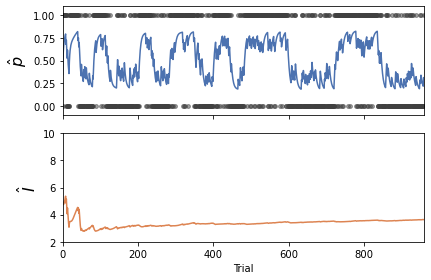

In [16]:
bayesian_learner_a.plot_history()

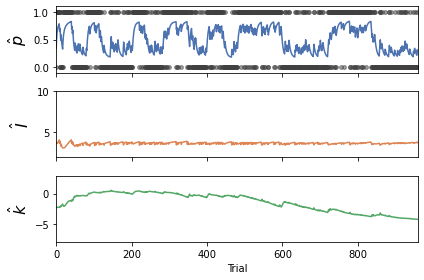

In [17]:
bayesian_learner_b.plot_history()